In [194]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


In [195]:
class KernelPCA2:
    def __init__(self, n_components=2, kernel='rbf', gamma=None):
        self.n_components = n_components
        self.kernel = kernel
        self.gamma = gamma

    def fit_transform(self, X):
        # Compute the kernel matrix
        K = self._compute_kernel_matrix(X)
        
        # Center the kernel matrix
        n_samples = K.shape[0]
        one_n = np.ones((n_samples, n_samples)) / n_samples
        K_centered = K - np.dot(one_n, K) - np.dot(K, one_n) + np.dot(np.dot(one_n, K), one_n)
        
        # Eigen decomposition
        eigen_values, eigen_vectors = np.linalg.eigh(K_centered)
        
        # Sort eigenvalues and eigenvectors
        indices = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[indices]
        eigen_vectors = eigen_vectors[:, indices]
        
        # Choose the top k eigenvectors (principal components)
        self.components_ = eigen_vectors[:, :self.n_components]
        
        # Project data onto the principal components
        return np.dot(K_centered, self.components_)

    def transform(self, X_new):
        # Compute the kernel matrix between new data and training data
        K_new = self._compute_kernel_matrix(X_new)
        
        # Center the kernel matrix
        n_samples_train = self.K_train.shape[0]
        n_samples_new = K_new.shape[0]
        one_n_train = np.ones((n_samples_train, n_samples_train)) / n_samples_train
        one_n_new = np.ones((n_samples_new, n_samples_train)) / n_samples_train
        K_new_centered = K_new - np.dot(one_n_new, self.K_train) - np.dot(K_new, one_n_train) + np.dot(np.dot(one_n_new, self.K_train), one_n_train)
        
        # Project new data onto the principal components
        return np.dot(K_new_centered, self.components_)

    def _compute_kernel_matrix(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        if self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1.0 / X.shape[1]  # Default gamma
            for i in range(n_samples):
                for j in range(n_samples):
                    K[i, j] = np.exp(-self.gamma * np.linalg.norm(X[i] - X[j])**2)
        else:
            raise ValueError("Unsupported kernel type. Only 'rbf' kernel is supported.")
        self.K_train = K  # Store the kernel matrix for training data
        return K

In [196]:
import numpy as np

class FisherLDA:
    def __init__(self, data, labels, n_components=2):
        self.data = data
        self.labels = labels
        self.unique_labels = np.unique(labels)
        self.n_classes = len(self.unique_labels)
        self.means = []
        self.n_components = n_components
        self.calculate_scatter_matrices()
        self.calculate_projection_vector()

    def calculate_scatter_matrices(self):
        # Compute class means and overall mean
        self.class_means = [self.data[self.labels == cls].mean(axis=0) for cls in self.unique_labels]
        self.overall_mean = self.data.mean(axis=0)

        # Calculate the within-class scatter matrix
        SW = np.zeros((self.data.shape[1], self.data.shape[1]))
        for cls in self.unique_labels:
            class_data = self.data[self.labels == cls]
            class_scatter = np.cov(class_data.T)
            SW += class_scatter

        # Calculate the between-class scatter matrix
        SB = np.zeros((self.data.shape[1], self.data.shape[1]))
        for cls, class_mean in zip(self.unique_labels, self.class_means):
            class_data = self.data[self.labels == cls]
            n_class = len(class_data)
            mean_diff = (class_mean - self.overall_mean).reshape(-1, 1)
            SB += n_class * (mean_diff @ mean_diff.T)

        self.SW_inv = np.linalg.inv(SW)
        self.SB = SB

    def calculate_projection_vector(self):
        # Calculate the transformation matrix
        A = self.SW_inv @ self.SB

        # Get the eigenvalues and eigenvectors
        eigen_values, eigen_vectors = np.linalg.eig(A)

        sorted_indices = np.argsort(eigen_values)[::-1]
        sorted_eigenvectors = eigen_vectors[:, sorted_indices]
        self.best_eigenvector = sorted_eigenvectors[:, :self.n_components]

    def project(self, data):
        print(self.best_eigenvector.shape)
        return data @ self.best_eigenvector

    def predict(self, data):
        # Project new data onto the LDA subspace
        projected_data = self.project(data)

        # Calculate distances to class centroids
        distances = []
        for class_mean in self.class_means:
            dist = np.linalg.norm(projected_data - class_mean, axis=1)
            distances.append(dist)

        # Assign the class with the minimum distance
        predicted_labels = np.argmin(distances, axis=0)

        return predicted_labels


(2, 1)


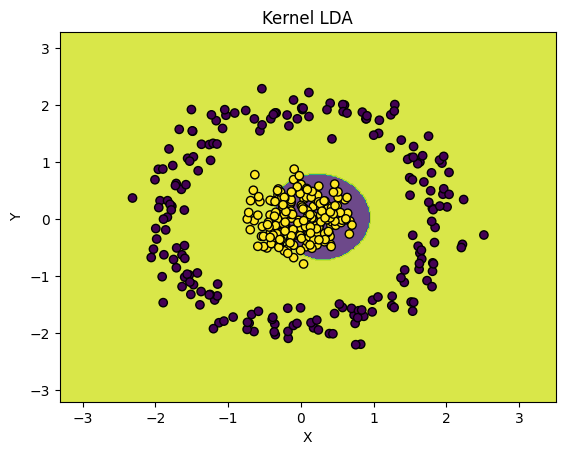

In [197]:
X, y = make_circles(n_samples=400, noise=0.1, factor=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kpca = KernelPCA(kernel="rbf", gamma=5)
X_kpca = kpca.fit_transform(X_scaled)

lda = FisherLDA(X_scaled, y, n_components=1)

h = 0.02
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Reshape the grid points to match the expected input shape for LDA transformation
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z_kpca = kpca.transform(grid_points)
Z_kpca = Z_kpca[:, :2]
Z_lda = lda.predict(Z_kpca)
Z_lda = Z_lda.reshape(xx.shape)

plt.contourf(xx, yy, Z_lda, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k')
plt.title('Kernel LDA')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()